http://jeroenjanssens.com/2013/09/19/seven-command-line-tools-for-data-science.html

In [197]:
import numpy as np
from os import path
data_dir = "/home/daniel/git/Python2.7/DataScience/nlp_training_data"

chap_line_nums = np.loadtxt(path.join(data_dir, 'alice_chap_nums.txt'), dtype='int', delimiter='\n')

f = open(path.join(data_dir,'alice.txt'), 'r')
lines = f.readlines()
f.close()
     
print chap_line_nums

[ 212  422  632  891 1160 1461 1792 2137 2454 2778 3077 3343 3637]


In [198]:
for i in range(chap_line_nums.size - 1):
    chap_num = i + 1
    f = open(path.join(data_dir,'chap_%02i.txt' %chap_num), 'w')
    
    start = chap_line_nums[i]
    end = chap_line_nums[i+1] - 1

    for line in lines[start:end]:
        f.write(line) 
    
    f.close()
    

In [199]:
from nltk import tokenize
import nltk
import re

In [200]:
def get_chap_sents(filename):
    f = open(filename, 'r')
    lines = f.read()
    f.close()

    sents = tokenize.sent_tokenize(lines)
    sents = map(lambda s:s.replace('\r\n',' '), sents)
    sents = map(lambda s:s.replace('_',''), sents)
    
    return sents

def join_n_sentences(sentences, n=6):
    new_lines = []
    num_sent = len(sentences)
    index = np.arange(0, num_sent, n)
    
    for i in index:
        concat_lines = ' '.join(sentences[i:i+n+1])
        new_lines.append(concat_lines)
        
    return new_lines    

def build_docs(filename):
    sents = get_chap_sents(filename)
    doc = join_n_sentences(sents)
    
    return doc

def get_nltk_pos(string):
    test = string.decode('ascii', 'ignore')
    test = tokenize.word_tokenize(test)
    pos = nltk.pos_tag(test)
    
    return pos

#pat = "^[NVJR]"
pat = "^[NVJ]"
reg = re.compile(pat)
def filter_pos(pos):
    out = []
    for item in pos:
        if reg.match(item[1]):
            out.append(item[0])
            
    return out        

def get_pos(doc):
    out = []
    for string in doc:
        pos = get_nltk_pos(string)
        #print pos
        temp = filter_pos(pos)
        string = ' '.join(temp)
        out.append(string)
    
    #out = [item for sub_list in out for item in sub_list]
    return out

def remove_short_words(pos, num_letters=4):
    out = []
    for word in pos.split(' '):
        if len(word) < num_letters:
            continue
        else:
            out.append(word)
         
    return ' '.join(out)    
      
        

In [201]:
import glob
import pandas as pd

chps = glob.glob(path.join(data_dir,"chap_*.txt"))
chps.sort()

for ch in chps:
    print ch
    

/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_01.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_02.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_03.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_04.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_05.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_06.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_07.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_08.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_09.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_10.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_11.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_12.txt


In [202]:
docs = build_docs(chps[0])
print docs[3] 
print '\n' + str(len(docs)) + " docs" + '\n'
docs = map(remove_short_words, docs)
print docs[3]

Would the fall never come to an end? "I wonder how many miles I've fallen by this time?" she said aloud. "I must be getting somewhere near the centre of the earth. Let me see: that would be four thousand miles down. I think--" (for, you see, Alice had learnt several things of this sort in her lessons in the schoolroom, and though this was not a very good opportunity for showing off her knowledge, as there was no one to listen to her, still it was good practice to say it over) "--yes, that's about the right distance--but then I wonder what Latitude or Longitude I've got to?" (Alice had no idea what Latitude was, or Longitude either, but thought they were nice grand words to say.)

15 docs

Would fall never come end? wonder many miles I've fallen this time?" said aloud. must getting somewhere near centre earth. see: that would four thousand miles down. think--" (for, see, Alice learnt several things this sort lessons schoolroom, though this very good opportunity showing knowledge, there 

In [203]:
pos = get_pos(docs)
print pos[0]

[ Sidenote Down Rabbit-Hole ] ALICE beginning tired sitting sister bank having nothing twice peeped book sister reading pictures conversations book thought Alice pictures conversations considering mind made feel sleepy stupid ) pleasure making daisy-chain worth trouble getting picking daisies White Rabbit pink eyes nothing remarkable Alice think hear Rabbit dear dear late thought afterwards occurred ought have wondered time seemed natural ) Rabbit took watch waistcoat-pocket looked hurried Alice started feet flashed mind seen rabbit waistcoat-pocket watch take burning curiosity field time large rabbit-hole hedge moment went Alice considering world


In [204]:
df = pd.DataFrame()

df['doc'] = pos
#df['doc'] = docs
df['chap'] = np.ones(len(pos))
df

,doc,chap
0,[ Sidenote Down Rabbit-Hole ] ALICE beginning ...,1
1,moment went Alice considering world rabbit-hol...,1
2,thought Alice herself such fall think nothing ...,1
3,fall come end wonder many miles 've fallen tim...,1
4,( Alice idea Latitude was Longitude thought we...,1
5,( tried curtsey spoke fancy curtseying 're fal...,1
6,Dinah 'll miss to-night think Dinah cat ) hope...,1
7,Alice began sleepy went saying sort way cats b...,1
8,thump came heap sticks leaves fall Alice hurt ...,1
9,came little three-legged table made solid glas...,1


In [205]:
for ind, _file in enumerate(chps[1:], start=2):
    docs = build_docs(_file)
    docs = map(remove_short_words, docs)
    pos = get_pos(docs)
    n = len(pos)
    temp = pd.DataFrame({ 'doc':pos, 'chap':np.ones(n)*ind })
    #print temp
    df = pd.concat([df, temp], axis=0)

df    

,chap,doc
0,1,[ Sidenote Down Rabbit-Hole ] ALICE beginning ...
1,1,moment went Alice considering world rabbit-hol...
2,1,thought Alice herself such fall think nothing ...
3,1,fall come end wonder many miles 've fallen tim...
4,1,( Alice idea Latitude was Longitude thought we...
5,1,( tried curtsey spoke fancy curtseying 're fal...
6,1,Dinah 'll miss to-night think Dinah cat ) hope...
7,1,Alice began sleepy went saying sort way cats b...
8,1,thump came heap sticks leaves fall Alice hurt ...
9,1,came little three-legged table made solid glas...


In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

In [234]:
for i in range(1, 13):
    print "chap", i, ":Num-chunks", df[df.chap == i].doc.count()

chap 1 :Num-chunks 15
chap 2 :Num-chunks 20
chap 3 :Num-chunks 20
chap 4 :Num-chunks 25
chap 5 :Num-chunks 23
chap 6 :Num-chunks 25
chap 7 :Num-chunks 30
chap 8 :Num-chunks 24
chap 9 :Num-chunks 28
chap 10 :Num-chunks 26
chap 11 :Num-chunks 21
chap 12 :Num-chunks 20


In [226]:
stop_words = ENGLISH_STOP_WORDS.union(['alice', 'illustration', 'thing', 'things'])

In [318]:
vectorizer = TfidfVectorizer(max_features=200,
                             lowercase=True,
                             max_df=28,
                             min_df=13,
                             use_idf=False,
                             stop_words=stop_words,
                             norm='l2',
                             ngram_range=(1, 2),
                             analyzer='word',
                             decode_error='ignore',
                             strip_accents='unicode'
                             )


matrix = vectorizer.fit_transform(df['doc'])
features = vectorizer.get_feature_names()
       
print matrix.shape 
print features
# vectorize the "docs"
# kmeans and store cluster in df

(277, 96)
[u'added', u'afraid', u'air', u'asked', u'begin', u'beginning', u'best', u'better', u'called', u'cat', u'caterpillar', u'change', u'child', u'coming', u'course', u'court', u'cried', u'curious', u'day', u'deal', u'dear', u'did', u'door', u'dormouse', u'duchess', u'face', u'feet', u'felt', u'garden', u'gave', u'getting', u'going', u'gone', u'good', u'half', u'hand', u'hands', u'hear', u'heard', u'high', u'house', u'idea', u'jury', u'kept', u'knew', u'left', u'life', u'like', u'long', u'majesty', u'make', u'matter', u'mind', u'minute', u'minutes', u'mouse', u'oh', u'pool', u'poor', u'question', u'remember', u'repeated', u'said duchess', u'said gryphon', u'said hatter', u'said king', u'said mock', u'say', u'saying', u'seen', u'silence', u'size', u'sort', u'speak', u'spoke', u'suppose', u'sure', u'table', u'talk', u'talking', u'tea', u'tears', u'till', u'took', u'tried', u'trying', u'turn', u'turned', u'used', u'way', u'white', u'white rabbit', u'wish', u'wonder', u'words', u'yes'

In [319]:
from sklearn.cluster import KMeans
k = len(chps)
km = KMeans(k)
assignments = km.fit_predict(matrix)

print np.unique(assignments)
    


[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [320]:
df['cluster_chaps'] = assignments + 1

In [321]:
print df[df.chap == 4]

    chap                                                doc  cluster_chaps
0      4  [ Sidenote Rabbit sends Little Bill ] White Ra...              5
1      4  Alice guessed moment looking pair white gloves...              2
2      4  surprised finds take gloves find said came nea...              2
3      4  began fancying sort thing happen 'Miss Alice C...             12
4      4  label time words DRINK nevertheless uncorked l...              2
5      4  wish went growing growing kneel floor minute r...              2
6      4  wish had gone rabbit-hole 's curious know sort...              2
7      4  comfort way woman have lessons learn like Oh f...             11
8      4  went taking first side other making conversati...             11
9      4  Alice knew Rabbit coming look trembled till sh...             11
10     4  Pat voice heard Sure Digging apples Digging ap...             11
11     4  Come help Sounds more broken glass ) tell Pat ...              6
12     4  arm goose size 

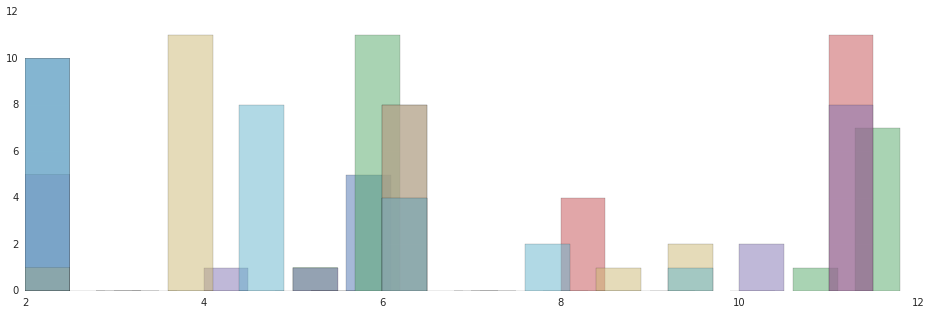

In [322]:
%matplotlib inline
for i in range(1, 7):
    df[df.chap == i]['cluster_chaps'].hist(figsize=(16,5), alpha=0.5, width=0.5)